In [4]:
import pandas as pd
import numpy as np
import tqdm.notebook as tq
from collections import defaultdict

import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

from sklearn.metrics import f1_score
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
NUM_CLASSES = 4
MAX_LEN = 100
BATCH = 8
PRE_TRAINED_MODEL_NAME = "distilbert-base-uncased" #'bert-base-cased'
EPOCHS = 8
LEARNING_RATE = 0.0001
THRESHOLD = 0.2
DROPOUT_RATE = 0.4
WEIGHT_DECAY = 0.001
MODE = 'min'
PATIENCE = 2
FACTOR = 0.5
VERBOSE = True

In [11]:
df = pd.read_csv('C:/Users/juwieczo/DataspellProjects/meisd_project/pipeline/balanced_augmented_data_primary_intensity.csv')
# Zamień wartości na liczby całkowite
# df['intensity'] = pd.to_numeric(df['intensity'], errors='coerce').fillna(0)
# df['intensity2'] = pd.to_numeric(df['intensity2'], errors='coerce').fillna(0)
# df['intensity3'] = pd.to_numeric(df['intensity3'], errors='coerce').fillna(0)

# Zamień wartości zawierające tylko białe znaki lub '`', 'neu', 'po' na NaN
# df['intensity'] = df['intensity'].replace(r'^\s*$', np.nan, regex=True)
# df['intensity'] = df['intensity'].replace(['`', 'neu', 'po'], np.nan)
# df['intensity2'] = df['intensity2'].replace(r'^\s*$', np.nan, regex=True)
# df['intensity2'] = df['intensity2'].replace(['`', 'neu', 'po'], np.nan)
# df['intensity3'] = df['intensity3'].replace(r'^\s*$', np.nan, regex=True)
# df['intensity3'] = df['intensity3'].replace(['`', 'neu', 'po'], np.nan)

# Użyj forward fill, aby uzupełnić brakujące wartości poprzedzającą wartością
# df['intensity'] = df['intensity'].ffill()
# df['intensity2'] = df['intensity2'].ffill()
# df['intensity3'] = df['intensity3'].ffill()

# Usuń znaki niebędące cyframi (np. '`') za pomocą wyrażeń regularnych
# df['intensity'] = df['intensity'].replace(r'\D', '', regex=True).astype(int)  # Usuwa wszystko, co nie jest cyfrą
# df['intensity2'] = df['intensity2'].replace(r'\D', '', regex=True).astype(int)
# df['intensity3'] = df['intensity3'].replace(r'\D', '', regex=True).astype(int)

missing_count = df['label'].isna().sum()
print(f"Liczba braków w kolumnie 'intensity': {missing_count}")
unique_values = df['label'].unique()
print(f"Unikalne wartości w kolumnie 'intensity': {unique_values}")

Liczba braków w kolumnie 'intensity': 0
Unikalne wartości w kolumnie 'intensity': [2 1 3 0]


In [12]:
#columns = ['Utterances', 'dialog_ids', 'uttr_ids', 'intensity', 'intensity2', 'intensity3']
columns = ['Utterances', 'label']
df = df[columns].copy()

In [13]:
# first_25_data = []
# last_25_data = []
# 
# def process_group(group):
#     num_rows = len(group)
#     quarter_size = max(1, num_rows // 4)
# 
#     # First 25%
#     first_25 = group.iloc[:quarter_size]
#     primary_intensity = max(
#         group['intensity'].iloc[0],
#         group['intensity2'].iloc[0],
#         group['intensity3'].iloc[0]
#     )
#     first_25 = first_25.assign(primary_intensity=primary_intensity)
# 
#     # Last 25%
#     last_25 = group.iloc[-quarter_size:]
#     final_intensity = max(
#         group['intensity'].iloc[-1],
#         group['intensity2'].iloc[-1],
#         group['intensity3'].iloc[-1]
#     )
#     last_25 = last_25.assign(final_intensity=final_intensity)
# 
#     first_25_data.append(first_25)
#     last_25_data.append(last_25)
# 
# df.groupby('dialog_ids').apply(process_group)
# 
# first_25_df = pd.concat(first_25_data).reset_index(drop=True)
# last_25_df = pd.concat(last_25_data).reset_index(drop=True)
# 
# grouped_first_25 = first_25_df.groupby('dialog_ids').agg({
#     'Utterances': ' '.join,
#     'primary_intensity': 'first'
# }).reset_index()
# 
# grouped_last_25 = last_25_df.groupby('dialog_ids').agg({
#     'Utterances': ' '.join,
#     'final_intensity': 'first'
# }).reset_index()
# 
# df = grouped_first_25.drop(df.columns[0], axis=1)
# 
# # grouped_first_25.to_csv('first_25_percent.csv', index=False)
# # grouped_last_25.to_csv('last_25_percent.csv', index=False)

In [14]:
#grouped_first_25.head()

In [16]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=50,
    truncation=True,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

print("Input IDs:", encodings["input_ids"])
print("Attention Mask:", encodings["attention_mask"])


Input IDs: tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [17]:
df.head()

,Utterances,label
0,"i'm george o'malley uh, we met at the mixer. y...",2
1,if he doesn't respond to these tests in the ne...,2
2,"without i.d., you can't contact the family wit...",2
3,"mr. humphrey, i'm sorry to wake you come on wh...",2
4,"means i have it all the time i know what ""chro...",2


In [18]:
token_lens = []

for txt in df['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

C:\Users\juwieczo\AppData\Local\Temp\ipykernel_16940\1466372787.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

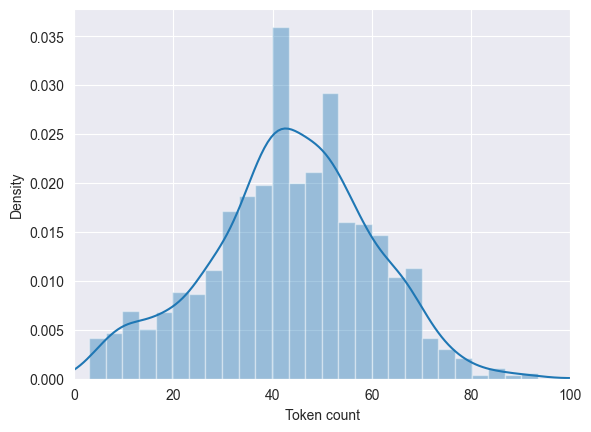

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 100])
plt.xlabel('Token count')

In [20]:
#df = grouped_first_25

In [21]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.df = df
        self.utterances = list(df['Utterances'])
        self.targets = self.df['label'].astype(int).values
        self.max_len = max_len

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, index):
        utterances = str(self.utterances[index])

        inputs = self.tokenizer.encode_plus(
            utterances,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        target = torch.tensor(self.targets[index], dtype=torch.long)

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.tensor(self.targets[index], dtype=torch.long),
            'utterances': utterances
        }


In [22]:
from sklearn.model_selection import train_test_split

# split into train and test
df_train, df_test = train_test_split(df, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [23]:
print(f"Original train size: {df.shape}")
print(f"Validation size: {df_valid.shape}, Test size: {df_test.shape}")

Original train size: (1584, 2)
Validation size: (238, 2), Test size: (238, 2)


In [24]:
label_frequencies = df_train['label'].value_counts()
label_frequencies_percent = df_train['label'].value_counts(normalize=True) * 100
print(label_frequencies_percent)
print(label_frequencies)

label
0    26.263538
1    25.902527
3    25.090253
2    22.743682
Name: proportion, dtype: float64
label
0    291
1    287
3    278
2    252
Name: count, dtype: int64


In [25]:
target_list = list(df.columns)
target_list = target_list[1:]
target_list

['label']

In [26]:
# class BERT_IntensityClass(torch.nn.Module):
#     def __init__(self, bert_model):
#         super(BERT_IntensityClass, self).__init__()
#         self.bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=True)
#         self.dropout = torch.nn.Dropout(p=DROPOUT_RATE) #0.5
#         self.linear = torch.nn.Linear(bert_model.config.hidden_size, NUM_CLASSES)
#         #self.softmax = nn.Softmax(dim=1) #remove for sentiment analysis
#         #CrossEntropyLoss automatycznie aplikuje funkcję softmax, więc nie ma potrzeby używać Softmax w modelu.
# 
# 
#     def forward(self, input_ids, attn_mask, token_type_ids=None):
#         output = self.bert_model(input_ids, attention_mask=attn_mask, token_type_ids=token_type_ids)
#         #pooler_output = self.pooler_output
#         dropout_output = self.dropout(output.pooler_output)
#         linear_output = self.linear(dropout_output)
#         #output = self.dropout(linear_output)
#         # output = self.softmax(linear_output)
#         return linear_output

In [27]:
class DistilBERT_IntensityClass(torch.nn.Module):
    def __init__(self, distilbert_model, dropout_rate=DROPOUT_RATE, num_classes=NUM_CLASSES):
        super(DistilBERT_IntensityClass, self).__init__()
        self.distilbert_model = distilbert_model
        self.dropout = torch.nn.Dropout(p=DROPOUT_RATE)
        self.linear = torch.nn.Linear(self.distilbert_model.config.hidden_size, num_classes)

    def forward(self, input_ids, attn_mask):
        # DistilBERT model processing
        output = self.distilbert_model(input_ids, attention_mask=attn_mask)

        # Use the last hidden state (the embedding for [CLS] token is at index 0)
        cls_output = output.last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]
        # Apply dropout
        dropout_output = self.dropout(cls_output)
        # Get final class logits
        linear_output = self.linear(dropout_output)
        return linear_output


In [28]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# model = BERT_IntensityClass(bert_model)
# model.to(device)
# tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [29]:
from transformers import DistilBertModel
distilbert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# for loop - blokowanie warst 
for i, layer in enumerate(distilbert_model.transformer.layer):
    if i < 2:
        for param in layer.parameters():
            param.requires_grad = False


model = DistilBERT_IntensityClass(distilbert_model)
model.to(device)
tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [30]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN)

In [31]:
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=0)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

In [32]:
# data = next(iter(train_data_loader))
# outputs = model(data["input_ids"], attn_mask=data["attention_mask"])
# print(outputs)

In [33]:
data = next(iter(train_data_loader))

In [34]:
# test_text = "We are testing BERT tokenizer."
# encodings = tokenizer.encode_plus(test_text,
#                                   add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
#                                   max_length=50,
#                                   truncation=True,
#                                   padding="max_length",
#                                   return_attention_mask=True,
#                                   return_tensors="pt")


In [35]:
from transformers import BertTokenizer, BertModel, DistilBertTokenizer

test_text = "We are testing BERT tokenizer."
encodings = tokenizer.encode_plus(
    test_text,
    add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
    max_length=50,
    truncation=True,
    padding="max_length",
    return_attention_mask=True,
    return_tensors="pt"
)

print("Input IDs:", encodings["input_ids"])
print("Attention Mask:", encodings["attention_mask"])


Input IDs: tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [36]:
# bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# last_hidden_state, pooled_output = bert_model(
#     input_ids=encodings['input_ids'],
#     attention_mask=encodings['attention_mask']
# )

In [37]:
# Pass the inputs through the DistilBERT model
output = distilbert_model(
    input_ids=encodings['input_ids'],
    attention_mask=encodings['attention_mask']
)

# Extract the last hidden state
last_hidden_state = output.last_hidden_state

# Extract the representation of the [CLS] token (first token in the sequence)
cls_output = last_hidden_state[:, 0, :]  # Shape: [batch_size, hidden_size]

# Now you can use cls_output for downstream tasks (e.g., classification)


In [38]:
class_distribution = df_train['label'].value_counts(normalize=True)
total_samples = sum(class_distribution)
class_weights = [total_samples / count for count in class_distribution]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([3.8076, 3.8606, 3.9856, 4.3968])

In [39]:
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(weight=class_weights)(outputs, targets)

In [40]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir='logs')

In [41]:
from transformers import AdamW, get_linear_schedule_with_warmup

#EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=MODE, patience=PATIENCE, factor=FACTOR, verbose=VERBOSE)

C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\juwieczo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [42]:
def train_model(training_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.train()
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), leave=True, colour='steelblue')

    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype=torch.long)
        mask = data['attention_mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.long)


# Forward pass
        outputs = model(ids, mask)

        # Calculate loss
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())

        # Calculate predictions and accuracy
        _, preds = torch.max(outputs, dim=1)
        correct_predictions += torch.sum(preds == targets).item()
        num_samples += targets.size(0)

        # Collect predictions and labels for F1-score
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

        # Backward pass and optimization
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

        # Update progress bar
        loop.set_postfix(batch_loss=loss.item())

    # Calculate F1-score for training data
    train_f1 = f1_score(all_labels, all_preds, average='weighted')

    return model, correct_predictions / num_samples, np.mean(losses), train_f1

In [43]:
def eval_model(validation_loader, model, epoch):
    losses = []
    correct_predictions = 0
    num_samples = 0
    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for data in validation_loader:
            ids = data['input_ids'].to(device, dtype=torch.long)
            mask = data['attention_mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.long)

            # Forward pass
            outputs = model(ids, mask)

            # Calculate loss
            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # Calculate predictions and accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == targets).item()
            num_samples += targets.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    avg_loss = np.mean(losses)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Logowanie do TensorBoard
    writer.add_scalar('Loss/validation', avg_loss, epoch)
    writer.add_scalar('F1-Score/validation', val_f1, epoch)

    return correct_predictions / num_samples, avg_loss, val_f1

In [36]:
from collections import defaultdict
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import io

history = defaultdict(list)
best_accuracy = 0
writer = SummaryWriter(log_dir='logs')

def plot_confusion_matrix(cm, class_names, epoch):
    figure = plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'Confusion Matrix at Epoch {epoch}')

    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image = torch.tensor(np.frombuffer(buf.getvalue(), dtype=np.uint8)).float()
    writer.add_image('Confusion Matrix', image, epoch)

    plt.close(figure)  

In [37]:
history = defaultdict(list)
best_f1 = 0

for epoch in range(1, EPOCHS + 1):
    print(f'Epoch {epoch}/{EPOCHS}')

    model, train_acc, train_loss, train_f1 = train_model(train_data_loader, model, optimizer)
    print(f'Train loss {train_loss:.4f} | Train accuracy {train_acc:.4f} | Train F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(val_data_loader, model, epoch)
    print(f'Val loss {val_loss:.4f} | Val accuracy {val_acc:.4f} | Val F1 {val_f1:.4f}')

    # Logowanie metryk do TensorBoard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('F1-Score/train', train_f1, epoch)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    if val_f1 > best_f1:
        torch.save(model.state_dict(), "best_model_state.bin")
        best_f1 = val_f1
        print("Saved new best model.")

    scheduler.step(val_loss)  # Tuning LR

writer.close()

Epoch 1/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 1.3494 | Train accuracy 0.3339 | Train F1 0.3291
Val loss 1.3065 | Val accuracy 0.3193 | Val F1 0.2639
Saved new best model.
Epoch 2/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.9893 | Train accuracy 0.5677 | Train F1 0.5597
Val loss 1.2301 | Val accuracy 0.4958 | Val F1 0.4742
Saved new best model.
Epoch 3/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.5749 | Train accuracy 0.7870 | Train F1 0.7865
Val loss 1.3236 | Val accuracy 0.5630 | Val F1 0.5586
Saved new best model.
Epoch 4/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.2988 | Train accuracy 0.8989 | Train F1 0.8985
Val loss 1.8443 | Val accuracy 0.5252 | Val F1 0.5197
Epoch 5/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.1339 | Train accuracy 0.9621 | Train F1 0.9622
Val loss 2.3016 | Val accuracy 0.5714 | Val F1 0.5736
Saved new best model.
Epoch 6/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.0289 | Train accuracy 0.9901 | Train F1 0.9901
Val loss 2.8688 | Val accuracy 0.5378 | Val F1 0.5502
Epoch 7/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.0038 | Train accuracy 0.9982 | Train F1 0.9982
Val loss 2.8072 | Val accuracy 0.5546 | Val F1 0.5511
Epoch 8/8


  0%|          | 0/139 [00:00<?, ?it/s]

Train loss 0.0016 | Train accuracy 0.9991 | Train F1 0.9991
Val loss 2.9227 | Val accuracy 0.5798 | Val F1 0.5851
Saved new best model.


In [38]:
#Validation

In [44]:
import json
def load_data(file_path):
    with open(file_path, "r", encoding='utf-8') as file:
        data = json.load(file)
    return data

def extract_seeker_data(data, key):
    result = []

    for entry in data:
        dialog = entry['dialog']
        seeker_dialog = [item['content'].strip() for item in dialog if item['speaker'] == 'seeker']

        quarter_length = max(1, len(seeker_dialog) // 4)

        if key == 'initial_emotion_intensity':
            selected_dialog = seeker_dialog[:quarter_length]
        elif key == 'final_emotion_intensity':
            selected_dialog = seeker_dialog[-quarter_length:]
        else:
            continue

        result.append({
            key: entry['survey_score']['seeker'][key],
            'dialog': selected_dialog
        })

    return result

dataset = load_data('C:/Users/juwieczo/DataspellProjects/meisd_project/pipeline/ESConv.json')

first_25_percent = extract_seeker_data(dataset, 'initial_emotion_intensity')
first_25_df = pd.DataFrame(first_25_percent)
first_25_df.columns = ['label', 'Utterances']
first_25_df.head()

,label,Utterances
0,5,"[Hello, I am having a lot of anxiety about qui..."
1,5,"[hello im looking for someone to talk to, im f..."
2,4,"[Hello, I'm concerned about my job. I have bee..."
3,4,"[I am dong good. You?, I have been staying hom..."
4,5,"[Infinitely complicated., Too many decisions. ..."


In [45]:
label_counts = first_25_df['label'].value_counts()
least_common_label = label_counts.idxmin()
first_25_df = first_25_df[first_25_df['label'] != least_common_label]
first_25_df['label'] = pd.to_numeric(first_25_df['label'], errors='coerce')
first_25_df['label'] = first_25_df['label'] - 2

In [46]:
# distilbert_model = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# model = DistilBERT_IntensityClass(distilbert_model)
# model.load_state_dict(torch.load("best_model_state.bin"))
# model.to(device)
# model.eval()

tokenizer = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
valid_dataset = CustomDataset(first_25_df, tokenizer, MAX_LEN)
val_data_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH, shuffle=False, num_workers=0)

C:\Users\juwieczo\AppData\Local\Temp\ipykernel_16940\3850424926.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

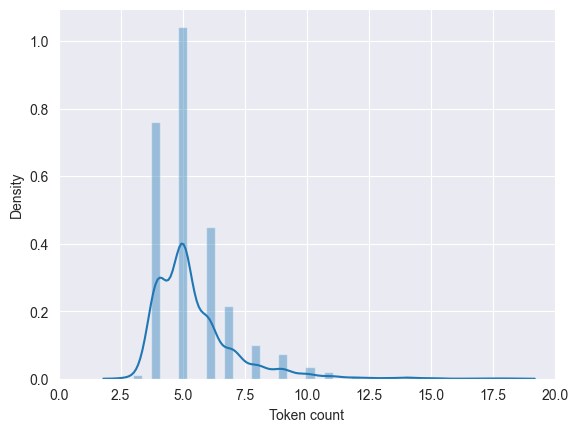

In [49]:
token_lens = []

for txt in first_25_df['Utterances']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(token_lens)
plt.xlim([0, 20])
plt.xlabel('Token count')

In [42]:
def validate_model(data_loader, model):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['targets'].to(device)

            outputs = model(input_ids=input_ids, attn_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

# Run validation
predictions, true_labels = validate_model(val_data_loader, model)

# Calculate metrics
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.20      0.27      0.23       267
           2       0.42      0.61      0.50       567
           3       0.27      0.07      0.11       427

    accuracy                           0.35      1298
   macro avg       0.22      0.24      0.21      1298
weighted avg       0.31      0.35      0.30      1298
